# Image Multiclass Classification Project

In [236]:
import pandas as pd # data analiz kütüphanesi, satır ve sütun tablosu
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns #####
import random
import os # sistem taskleri yerine getirmek için (götüntüleme, ekleme çıkarma gibi.)
import glob #belirli uzantılı dosyaları bulmak için
import cv2 # görüntü işleme, görüntü getirme vb.

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder # 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Veri kümesi oluşturma

In [237]:
main_path = ""
train_path = os.path.join(main_path,"data")

In [238]:
train_tsirts = glob.glob(train_path+"/tsirts/*.jpg")
train_sweatshirt = glob.glob(train_path+"/sweatshirt/*.jpg")
train_pants = glob.glob(train_path+"/pants/*.jpg")

In [239]:
#Loop a sokup, yukarıda görülen bütün .jpg dosyalarını listeliyoruz :
train_list = [x for x in train_tsirts]
train_list.extend([x for x in train_sweatshirt])
train_list.extend([x for x in train_pants])

#satır ve sütun tablosu
df_train = pd.DataFrame(np.concatenate([
                       ['0']*len(train_tsirts),
                       ['1']*len(train_sweatshirt),
                       ['2']*len(train_pants)]),
                    columns = ['label'])
df_train['image'] = [x for x in train_list]

In [406]:
df_train

,label,image
0,0,data/tsirts\-.jpg
1,0,data/tsirts\-2.jpg
2,0,data/tsirts\-com-fruit-of-the-loom-sleeve-t-shirts-5abde166662934.3573392215223934464185.jpg
3,0,data/tsirts\-din-t-shirt-med-dit-egen-oploadet-bil-5b67d9f982e579.1352946415335326655362.jpg
4,0,data/tsirts\-faintest-idea-flying-the-japanese-flag-png-favpng-PjWP5wrwWfYCC3B1A9CrwTPPd.jpg
...,...,...
3967,2,data/pants\_57.JPG2.jpg
3968,2,data/pants\_57.JPG3.jpg
3969,2,data/pants\_57.JPG4.jpg
3970,2,data/pants\_57.JPG6.jpg


# Önişleme

In [241]:
path = ''
img_list = list(df_train['image'])
data_img = [] #oluşturulan array adı
for each in img_list:
    each_path = os.path.join(path, each)# 3 dosya yolu için
    print(each_path)
    each_img = cv2.imread(each_path) # her resim için
    each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB) # rgb renklerine dönüştürme (resimler 3 depth kazanır)
    each_img_resized = cv2.resize(each_img, (128,128)) # resimlerin boyutu 128x128
    data_img.append(each_img_resized) # boyutları ve renkleri değişmiş bütün resimler liste haline getirilir
    
X = np.array(data_img) # oluşturulan liste NumPy array'e dönüştürülür.


data/tsirts\-.jpg
data/tsirts\-2.jpg
data/tsirts\-com-fruit-of-the-loom-sleeve-t-shirts-5abde166662934.3573392215223934464185.jpg
data/tsirts\-din-t-shirt-med-dit-egen-oploadet-bil-5b67d9f982e579.1352946415335326655362.jpg
data/tsirts\-faintest-idea-flying-the-japanese-flag-png-favpng-PjWP5wrwWfYCC3B1A9CrwTPPd.jpg
data/tsirts\0.jpg
data/tsirts\000-impressive-t-shirt-design-template-ai-example-1920_1884.jpg
data/tsirts\0009695241_10.jpg
data/tsirts\0009695241_102.jpg
data/tsirts\0018_E.jpg
data/tsirts\0018_E2.jpg
data/tsirts\003-unforgettable-t-shirt-template-vector-high-resolution-1920_1012.jpg
data/tsirts\008-sensational-plain-t-shirt-template-ideas-868_620.jpg
data/tsirts\009-awful-t-shirt-design-template-photoshop-inspirations-1920_987.jpg
data/tsirts\009-beautiful-blank-tee-shirt-template-high-resolution-1920_1372.jpg
data/tsirts\02.jpg
data/tsirts\03.jpg
data/tsirts\032.jpg
data/tsirts\03512f1f3d68802664cb765f4f59fed4-1-600x600.jpg
data/tsirts\04326.jpg
data/tsirts\051f9c1db6622a8

In [242]:
print('Shape of X: ', X.shape) # NumPy dizininde 3972 adet resim bulunuyor ve resimler 128x128 ve 3 derinlikte(renk)

Shape of X:  (3972, 128, 128, 3)


In [243]:
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))

In [244]:
print('Shape of y: ', y.shape)

Shape of y:  (3972, 3)


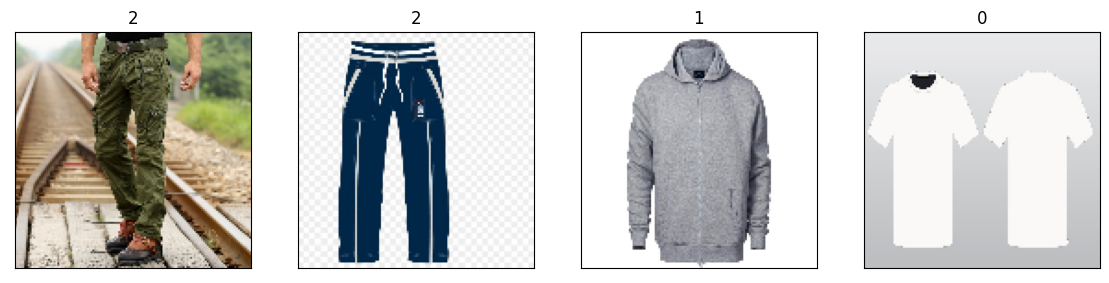

In [245]:
indices = np.random.randint(0,3972,4)
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(df_train['label'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

# Görüntü Sınıflandırma

In [246]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)
#

X_train shape:  (2700, 128, 128, 3)
y_train shape:  (2700, 3)
X_val shape  :  (676, 128, 128, 3)
y_val shape  :  (676, 3)
X_test shape :  (596, 128, 128, 3)
y_test shape :  (596, 3)


In [277]:
#Data augmentation çünkü overfitting
train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 15,
                               #rescale=1./255,
                               zoom_range=0.2,
                               shear_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1)
validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 15,
                                    #rescale=1./255,
                                    zoom_range=0.2,
                                    height_shift_range = 0.1,
                                    width_shift_range = 0.1)
train_gen.fit(X_train)
validation_gen.fit(X_val)

In [327]:
batch_size = 50
epochs = 4

In [328]:
base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x) # 2B a dönüştürür

In [329]:
head = Dense(3, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)

In [330]:
model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)

In [331]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_11[0][0]']               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [332]:
history = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

Epoch 1/4
54/54 [==============================] - 176s 3s/step - loss: 0.4766 - accuracy: 0.8496 - val_loss: 0.2740 - val_accuracy: 0.8831
Epoch 2/4
54/54 [==============================] - 175s 3s/step - loss: 0.0734 - accuracy: 0.9822 - val_loss: 0.0446 - val_accuracy: 0.9837
Epoch 3/4
54/54 [==============================] - 175s 3s/step - loss: 0.0310 - accuracy: 0.9900 - val_loss: 0.0150 - val_accuracy: 0.9970
Epoch 4/4
54/54 [==============================] - 176s 3s/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 0.0070 - val_accuracy: 0.9985


# Sonuçları analiz etme 

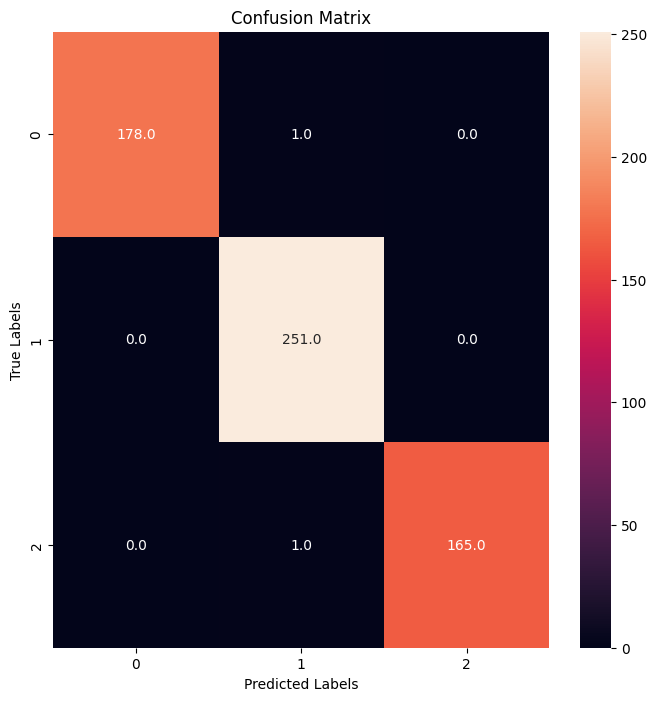

In [335]:
# Predicting labels from X_test data
y_pred = model.predict(X_test)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)
# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [336]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       179
           1       0.99      1.00      1.00       251
           2       1.00      0.99      1.00       166

    accuracy                           1.00       596
   macro avg       1.00      1.00      1.00       596
weighted avg       1.00      1.00      1.00       596



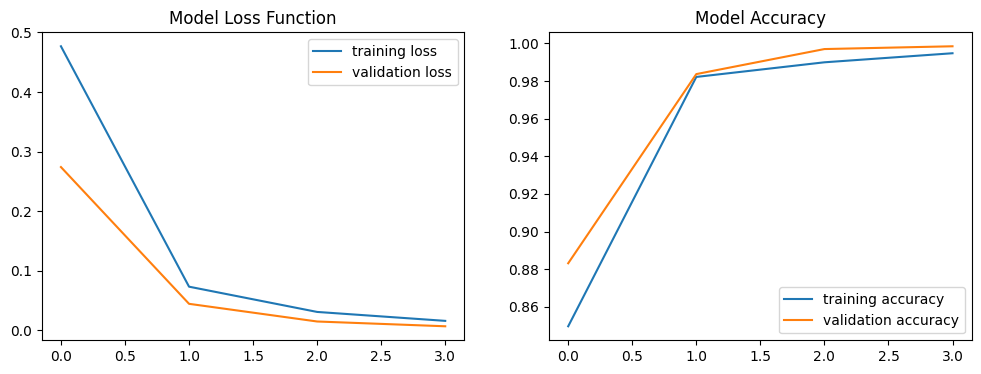

In [338]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();

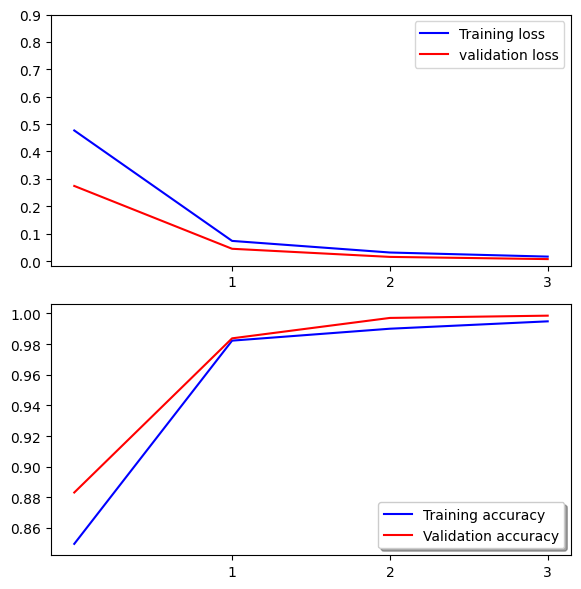

In [341]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Test

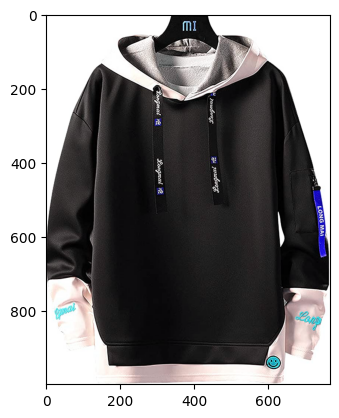

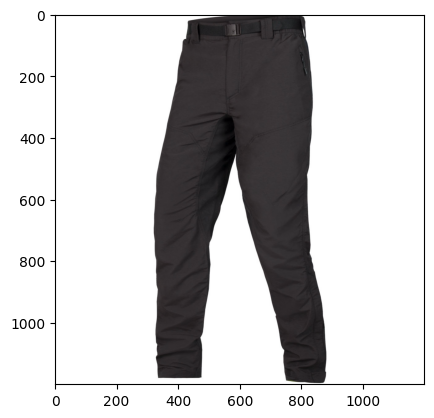

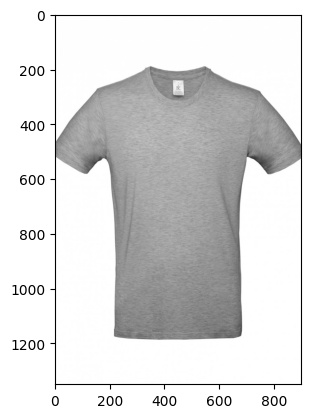

In [342]:
img = cv2.imread('sweat1.jpg')
plt.imshow(img)
plt.show()
img2 = cv2.imread('pant.jpg')
plt.imshow(img2)
plt.show()
img3 = cv2.imread('sirt.jpg')
plt.imshow(img3)
plt.show()

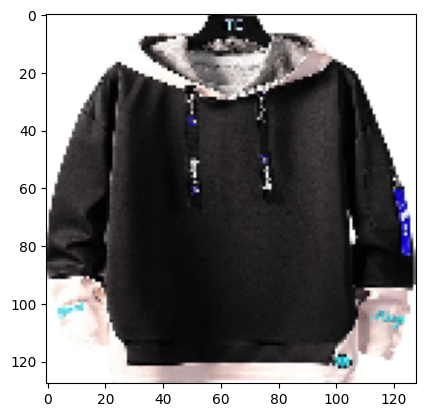

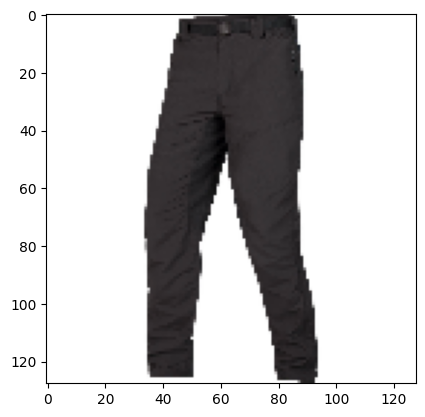

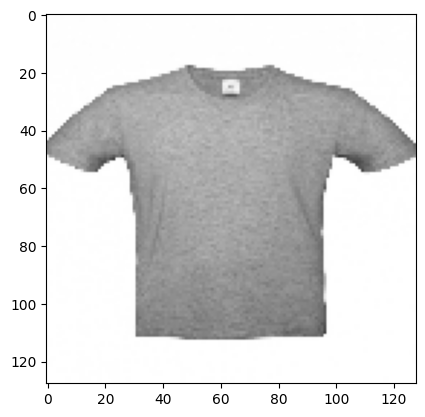

In [343]:
resize = tf.image.resize(img, (128,128))
plt.imshow(resize.numpy().astype(int))
plt.show()
resize2 = tf.image.resize(img2, (128,128))
plt.imshow(resize2.numpy().astype(int))
plt.show()
resize3 = tf.image.resize(img3, (128,128))
plt.imshow(resize3.numpy().astype(int))
plt.show()

In [368]:
denemesweat = model.predict(np.expand_dims(resize/1, 0))
denemepant = model.predict(np.expand_dims(resize2/1, 0))
denemetshirt = model.predict(np.expand_dims(resize3/1, 0))

['0.001', '0.997', '0.000']

In [371]:
yhat3

array([[9.9906117e-01, 1.9400801e-04, 7.4487459e-04]], dtype=float32)

In [374]:
print("    0:Tshirts    1:sweatshirts   2:Trousers \n\n", denemesweat, "\n", denemepant, "\n", denemetshirt, "\n")

  0:Tshirts      1:sweatshirts   2:Trousers 

 [[1.6105190e-05 9.9998224e-01 1.6633078e-06]] 
 [[2.2626194e-04 4.1560532e-04 9.9935812e-01]] 
 [[9.9906117e-01 1.9400801e-04 7.4487459e-04]] 



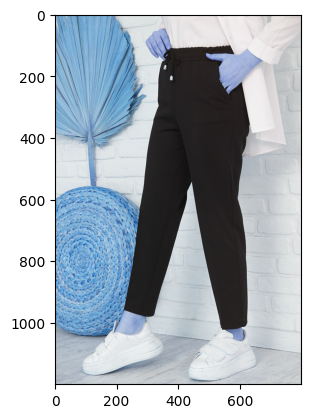

In [351]:
img4 = cv2.imread('pant22.jpg')
plt.imshow(img4)
plt.show()


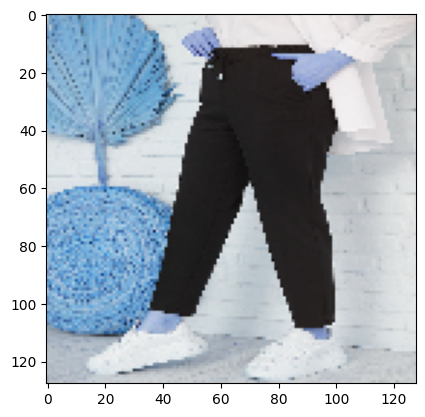

In [352]:
resize4 = tf.image.resize(img4, (128,128))
plt.imshow(resize4.numpy().astype(int))
plt.show()

In [364]:
kek = model.predict(np.expand_dims(resize4/1, 0))

In [365]:
kek

array([[0.00908684, 0.0029868 , 0.98792636]], dtype=float32)

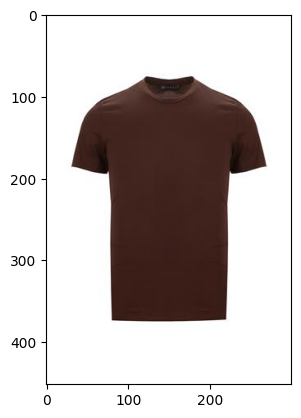

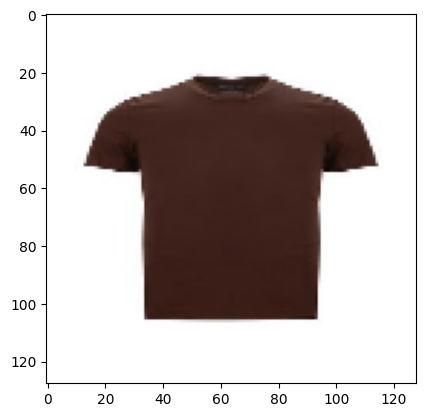

In [366]:
img5 = cv2.imread('sirt99.jpg')
plt.imshow(img5)
plt.show()
resize5 = tf.image.resize(img5, (128,128))
plt.imshow(resize5.numpy().astype(int))
plt.show()

kek2 = model.predict(np.expand_dims(resize5/1, 0))

In [367]:
kek2


array([[9.9867368e-01, 4.1258411e-04, 9.1372425e-04]], dtype=float32)

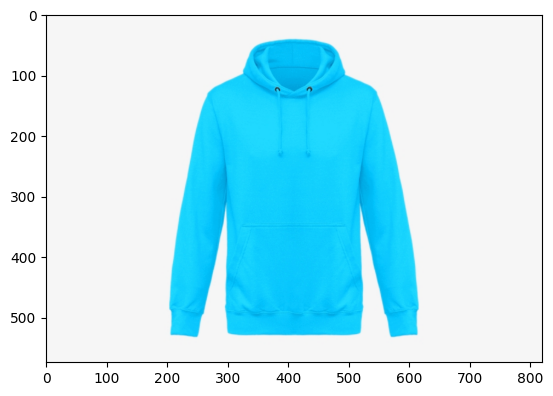

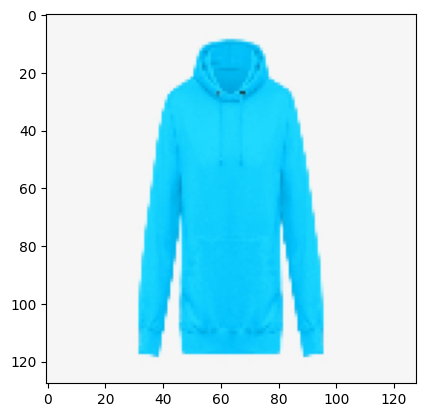

In [404]:
img6 = cv2.imread('sweat22.jpg')
plt.imshow(img6)
plt.show()
resize6 = tf.image.resize(img6, (128,128))
plt.imshow(resize6.numpy().astype(int))
plt.show()

kek6 = model.predict(np.expand_dims(resize6/1, 0))

In [407]:
kek6

array([[1.1947752e-03, 9.9783772e-01, 9.6756866e-04]], dtype=float32)

In [ ]:
def rounder(a):
    return list(map(lambda x: str (x)[:5],a[0]))

In [ ]:
rounder( kek6)